# SIR II (Epidemic modeling)

<br></br>

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-color.svg" height="200" width="200"/>

<br></br>
 <center>by <i>Zhuofei</i>(fregot@icloud.com)</center>
 
<br></br>
********************
在这个模型中，考虑一个在一定空间内的流行病模型。人只能与附近的人交互作用，所以给人在一定的空间里随机运动。

首先，在一个2维平面，随机游走：

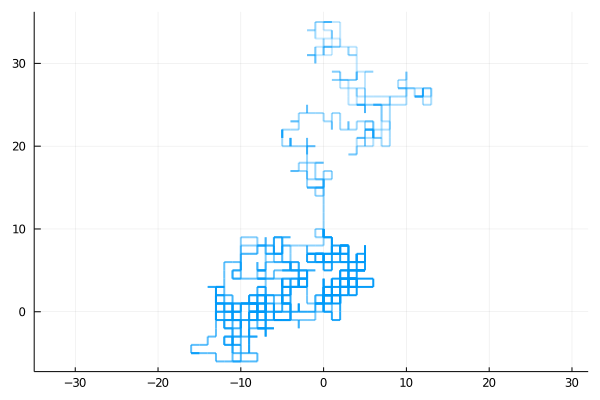

In [1]:
using Plots
using Compose
using Cairo
using Fontconfig
struct Coordinate{T}
	x::T
	y::T
end

#定义 +
function Base.:+(a::Coordinate, b::Coordinate)
	return Coordinate(a.x+b.x, a.y+b.y)
end

possiblemoves = [
	Coordinate( 1, 0), 
 	Coordinate( 0, 1), 
 	Coordinate(-1, 0), 
 	Coordinate( 0,-1),
 ]
#每一步随机取possiblemoves中的一个，加上去，形成随机游走

function randwalk(P::Coordinate, n::Int)
    accumulate(+, rand(possiblemoves, n); init = P)
end

#绘图
function p_tuple(c)
 	c.x, c.y
 end
P = plot(ratio=1)
pline = randwalk(Coordinate(4,4), 1000)
figure = plot!(P, p_tuple.(pline),label=nothing, linewidth=2, linealpha=LinRange(1.0, 0.2, length(pline)))
#savefig(figure,"figure1.png")

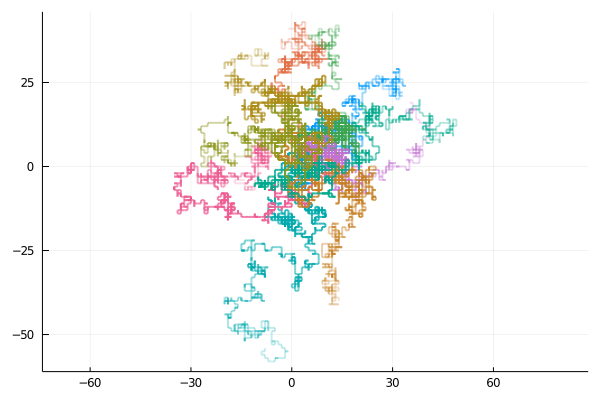

In [2]:
function p_plot(p::Plots.Plot, line::Vector)
    plot!(p, p_tuple.(line), label=nothing,
        linewidth=2, linealpha=LinRange(1.0, 0.2, length(pline)))
end
p1 = plot(ratio=1)

for i ∈ 1:10
    p_plot(p1, randwalk(Coordinate(4,4), 1000))
end
p1

*****************
给定一个空间，点在空间中移动，一旦超过边界，返回点在边界上：

空间大小为：$L\times L$

In [3]:
function boundary(c::Coordinate, L::Number)
	x, y = [c.x, c.y]
	if c.x < -L
		x = -L
	elseif c.x > L
		x = L
	end
	if c.y < -L
		y = -L
	elseif c.y > L
		y = L
	end
	return Coordinate(x, y)
end

boundary (generic function with 1 method)

然后利用边界对随机游走进行限制


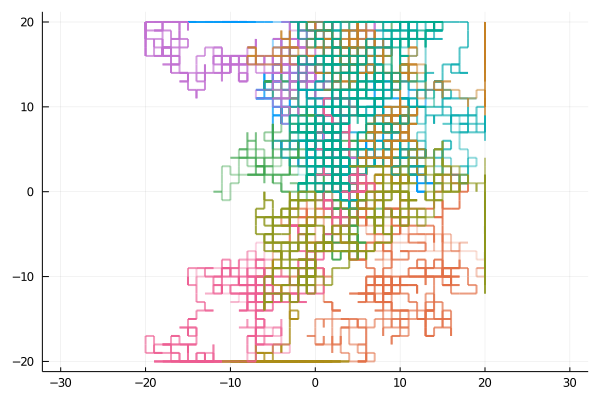

In [4]:
function randwalk_boundary(P::Coordinate, n::Int, L::Number)
    res = accumulate(+, rand(possiblemoves, n); init = P)
    return boundary.(res, L)
end
p1 = plot(ratio=1)

for i ∈ 1:10
    p_plot(p1, randwalk_boundary(Coordinate(4,4), 1000, 20))
end
p1

<br></br>
定义一个结构，每个人包括一个位置坐标和一个感染状况。

In [5]:
@enum InfectionStatus S I R
abstract type AbstractAgent end
mutable struct Agent <: AbstractAgent
    position::Coordinate
    status::InfectionStatus
end

初始化，生成一堆人，随机挑选一个设为感染者：

In [6]:
function initialize(N::Number, L::Number)
    res = []
    for i ∈ 1:N
        push!(res, Agent(Coordinate(rand(-L:L), rand(-L:L)), S))
    end
    ranNum = rand(1:N)
    res[ranNum].status = I
    return res
end

initialize (generic function with 1 method)

In [7]:
initialize(3, 10)

3-element Array{Any,1}:
 Agent(Coordinate{Int64}(-7, -5), S)
 Agent(Coordinate{Int64}(-5, 5), I)
 Agent(Coordinate{Int64}(-6, 10), S)

对每一种人用不同的颜色表示：

In [8]:
#deepskyblue,salmon,limegreen
color(s::InfectionStatus) = if s == S
    "deepskyblue"
    elseif s == I
        "salmon"
    else
        "limegreen"
    end

color(a::Agent) = color(a.status)


color (generic function with 2 methods)

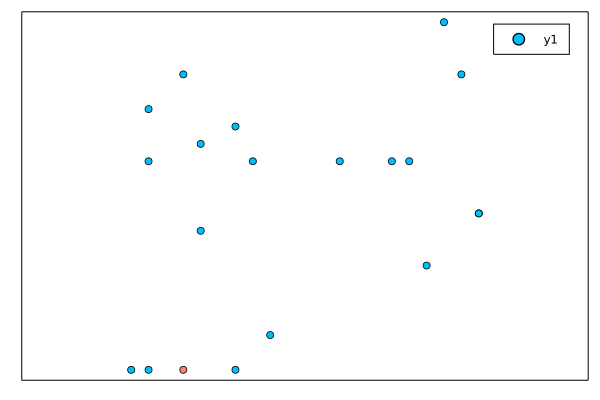

In [40]:
#将初始化的人，可视化
function visualize(agents::Vector, L)
    p = plot(ratio=1, framestyle = :box, xaxis=nothing, yaxis=nothing)
    c = color.(agents)
    l = length(agents)
    scatter!([agents[i].position.x for i=1:l], [agents[i].position.y for i=1:l], c=c)
    return p
end
N = 20
L = 10
visualize(initialize(N, L), L)

<br></br>
像之前模型一那样,定义传染的函数：

In [41]:
abstract type AbstractInfection end


struct CollisionInfectionRecovery <: AbstractInfection
    p_infection::Float64
    p_recovery::Float64
end

In [42]:
function bernoulli(p)
    return rand() ≤ p
end

bernoulli (generic function with 1 method)

In [48]:
#重合有几率感染
function interact!(agent::Agent, source::Agent, infection::CollisionInfectionRecovery)
    if source.position == agent.position && bernoulli(infection.p_infection)
        if agent.status == S && source.status == I
            agent.status = I
        elseif source.status == S && agent.status == I
            source.status = I
        end
    elseif agent.status == I && bernoulli(infection.p_recovery)
        agent.status = R
    end
    return (agent, source)
end

interact! (generic function with 1 method)

In [44]:
function step!(agents::Vector, L::Number, infection::AbstractInfection)
    ranNum = rand(1:length(agents)) 
    agents[ranNum].position += rand(possiblemoves)
    agents[ranNum].position = boundary(agents[ranNum].position, L)
    for i ∈ 1:length(agents)
        if i ≠ ranNum
            agents[i], agents[ranNum] = interact!(agents[i], agents[ranNum], infection)
        end
    end
    return agents
end

step! (generic function with 1 method)

In [21]:
function sweep!(agents::Vector, L::Number, infection::AbstractInfection)
    for i ∈ 1:length(agents)
        agents = step!(agents, L, infection)
    end
    return agents
end

sweep! (generic function with 1 method)

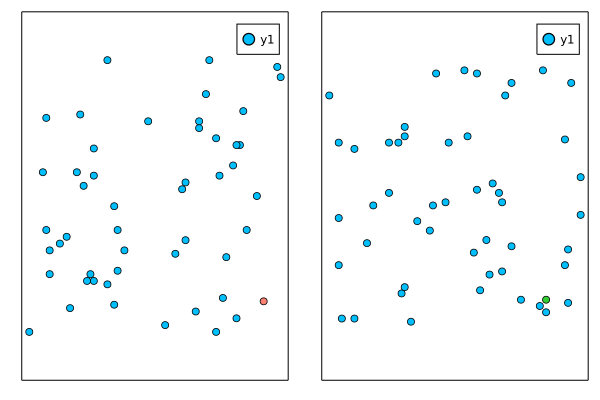

In [45]:
pandemic = CollisionInfectionRecovery(0.5, 10^-5)
function SimulateTest(N::Int64, L::Number, ksweeps::Number)
    agents = initialize(N, L)
    plot_before = visualize(agents, L) # replace with your code
    for i ∈ 1:ksweeps
        agents = sweep!(agents, L, pandemic)
    end
    plot_after = visualize(agents, L)
    p = plot(plot_before, plot_after)
    return p
end

SimulateTest(50, 40, 1000)

#需要按照WebIO扩展
#@manipulate for ksweeps ∈ 1:10000
#    SimulateTest(50, 40, ksweeps)
#end


    

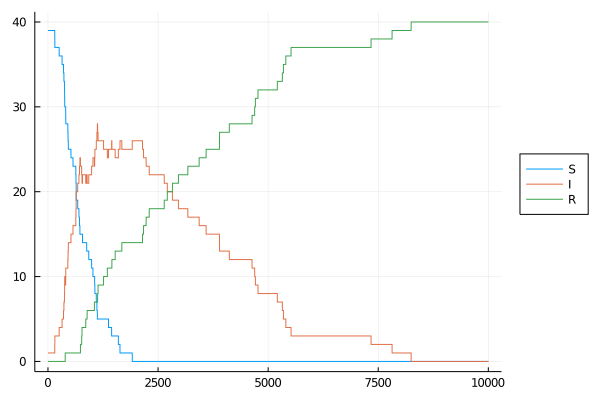

In [46]:
#Count
k_sweep_max = 10000
function countingSIR(agents::Vector)
    result_S, result_I, result_R = 0, 0, 0
    for i in agents
        if i.status == S
            result_S += 1
        elseif i.status == I
            result_I += 1
        elseif i.status == R
            result_R += 1
        end
    end
    return (result_S, result_I, result_R)
end

#40人， 30×30面积
N = 40
L = 30
    

agents = initialize(N, L)
result_S = Int[]
result_I = Int[]
result_R = Int[]
for t ∈ 1:k_sweep_max
    agents = sweep!(agents, L, pandemic)
    s, i, r = countingSIR(agents)
    push!(result_S, s)
    push!(result_I, i)
    push!(result_R, r)
end
p = plot(leg=:outerright)
plot!(result_S, label="S")
plot!(result_I, label="I")
plot!(result_R, label="R")

┌ Info: Saved animation to 
│   fn = /Users/zhouzhuofei/tmp.gif
└ @ Plots /Users/zhouzhuofei/.julia/packages/Plots/lmp2A/src/animation.jl:104


Plots.AnimatedGif("/Users/zhouzhuofei/tmp.gif")
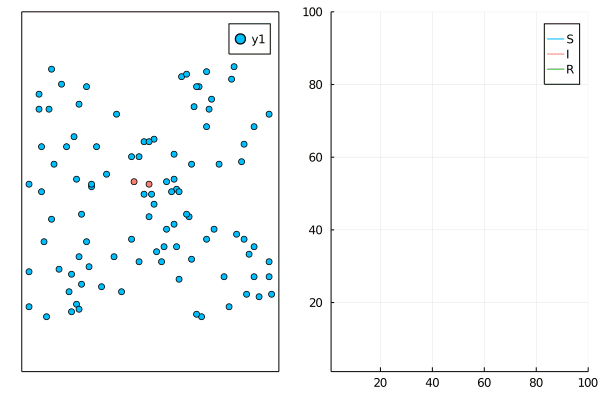

In [61]:
N = 100
L = 50
x = initialize(N, L)
pandemicI = CollisionInfectionRecovery(0.5, 0.00001)

Ss, Is, Rs = Int[], Int[], Int[]
    

Tmax = 100

@gif for t ∈ 1:Tmax
    
    for i ∈ 1:50N
        step!(x, L, pandemicI)
    end
    result_SIR = countingSIR(x)
    push!(Ss, result_SIR[1])
    push!(Is, result_SIR[2])
    push!(Rs, result_SIR[3])
    l = visualize(x, L)
    r = plot(xlim=(1, Tmax), ylim=(1, N))
    plot!(r, 1:t, Ss, color=color(S), label="S")
    plot!(r, 1:t, Is, color=color(I), label="I")
    plot!(r, 1:t, Rs, color=color(R), label="R")
    plot(l, r)
end

<br></br>
************

现在添加社交，社交概率：越大越可能接触

In [49]:
mutable struct SocialAgent <: AbstractAgent
    position::Coordinate
    status::InfectionStatus
    num_infected::Int
    social_score::Float64
end

In [50]:
position(a::SocialAgent) = a.position
color(a::SocialAgent) = color(a.status)

color (generic function with 3 methods)

In [51]:
function initialize_social(N, L)
    res = []
    for i ∈ 1:N
        push!(res, SocialAgent(Coordinate(rand(-L:L), rand(-L:L)), S, 0, rand(0.1:0.01:0.5)))
    end
    ranNum = rand(1:N)
    res[ranNum].status = I
    return res
end

initialize_social (generic function with 1 method)

In [52]:
#社交概率和感染概率决定是否被感染
function interact!(agent::SocialAgent, source::SocialAgent, infection::CollisionInfectionRecovery)
    total_scores = agent.social_score + source.social_score
    if source.position == agent.position && bernoulli(infection.p_infection) && bernoulli(total_scores)
        if agent.status == S && source.status == I
            agent.status = I
        elseif source.status == S && agent.status == I
            source.status = I
        end
    elseif agent.status == I && bernoulli(infection.p_recovery)
        agent.status = R
    end
    return (agent, source)
end

interact! (generic function with 2 methods)

┌ Info: Saved animation to 
│   fn = /Users/zhouzhuofei/tmp.gif
└ @ Plots /Users/zhouzhuofei/.julia/packages/Plots/lmp2A/src/animation.jl:104


Plots.AnimatedGif("/Users/zhouzhuofei/tmp.gif")
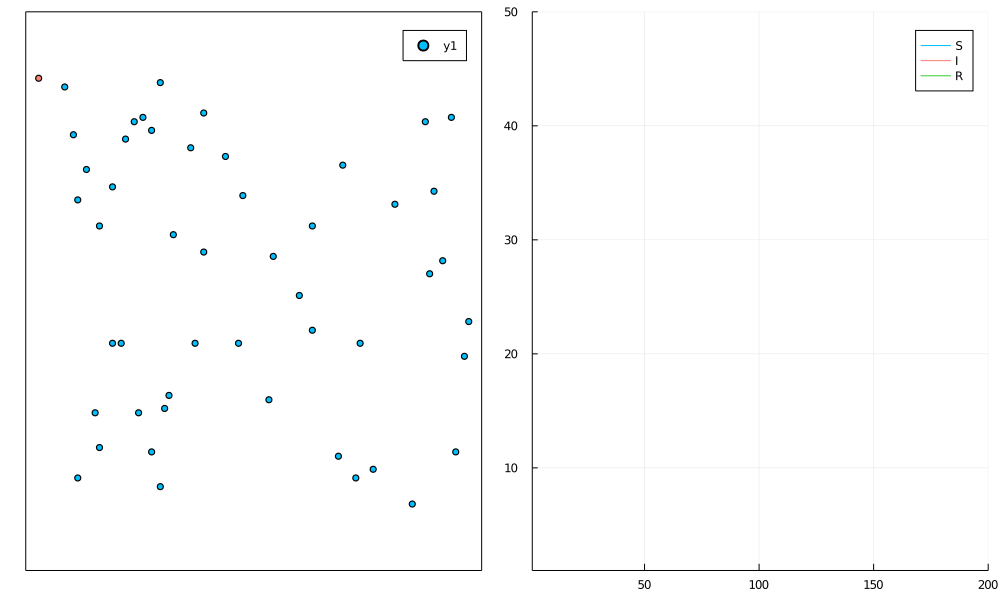

In [62]:
N = 50
L = 50

global social_agents = initialize_social(N, L)
x = copy(social_agents)
pandemicI = CollisionInfectionRecovery(0.5, 0.00001)

Ss, Is, Rs = Int[], Int[], Int[]
    

Tmax = 200

@gif for t ∈ 1:Tmax
    
    for i ∈ 1:50N
        step!(x, L, pandemicI)
    end
    result_SIR = countingSIR(x)
    push!(Ss, result_SIR[1])
    push!(Is, result_SIR[2])
    push!(Rs, result_SIR[3])
    l = visualize(x, L)
    r = plot(xlim=(1, Tmax), ylim=(1, N))
    plot!(r, 1:t, Ss, color=color(S), label="S")
    plot!(r, 1:t, Is, color=color(I), label="I")
    plot!(r, 1:t, Rs, color=color(R), label="R")
    plot(l, r, size=(1000, 600))
end

┌ Info: Saved animation to 
│   fn = /Users/zhouzhuofei/tmp.gif
└ @ Plots /Users/zhouzhuofei/.julia/packages/Plots/lmp2A/src/animation.jl:104


Plots.AnimatedGif("/Users/zhouzhuofei/tmp.gif")
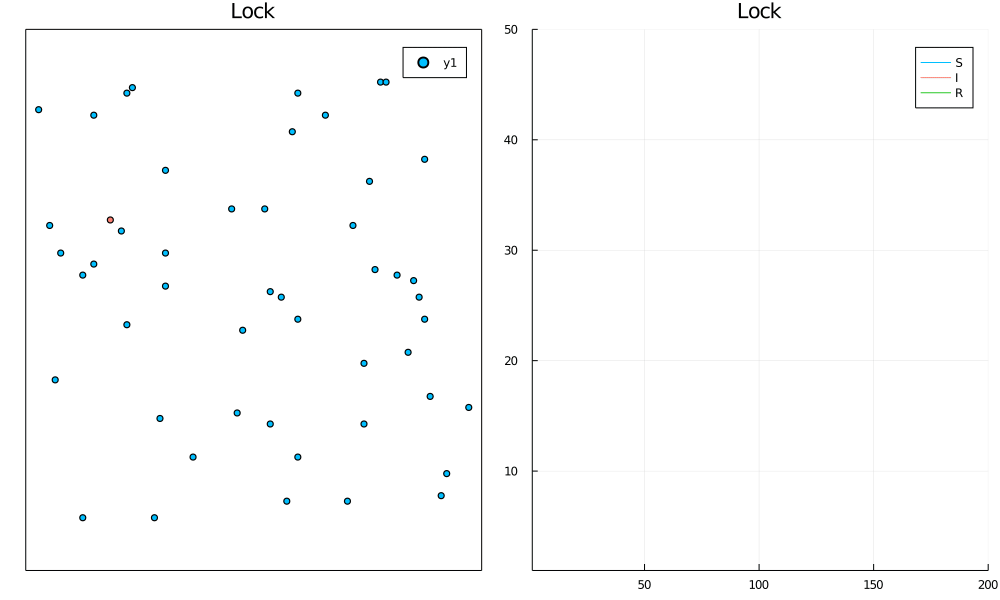

In [60]:
N = 50
L = 40


x = initialize_social(N, L)
for i in 1:N
    x[i].social_score *= 0.25
end
pandemicI = CollisionInfectionRecovery(0.5, 0.00001)

Ss, Is, Rs = Int[], Int[], Int[]
    

Tmax = 200

@gif for t ∈ 1:Tmax
    
    for i ∈ 1:50N
        step!(x, L, pandemicI)
    end
    result_SIR = countingSIR(x)
    push!(Ss, result_SIR[1])
    push!(Is, result_SIR[2])
    push!(Rs, result_SIR[3])
    l = visualize(x, L)
    r = plot(xlim=(1, Tmax), ylim=(1, N))
    plot!(r, 1:t, Ss, color=color(S), label="S")
    plot!(r, 1:t, Is, color=color(I), label="I")
    plot!(r, 1:t, Rs, color=color(R), label="R")
    plot(l, r, size=(1000, 600), title="Lock")
end